Imports and setup

In [30]:

import torch 
print(torch.__version__)
import torchvision

1.12.1+cu116


In [19]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import argparse
import os
import os.path as osp
import torch.nn.functional as F
import torch.nn as nn

# import matplotlib
# %matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import tqdm
from dataloaders import fundus_dataloader as DL
from torch.utils.data import DataLoader
from dataloaders import custom_transforms as tr
from torchvision import transforms
# from scipy.misc import imsave
from matplotlib.pyplot import imsave
from utils.Utils import *
from utils.metrics import *
from datetime import datetime
import pytz
import networks.deeplabv3 as netd
import networks.deeplabv3_eval as netd_eval
import cv2
import torch.backends.cudnn as cudnn
import random
from tensorboardX import SummaryWriter

from sklearn.manifold import TSNE
        

In [20]:
#TSNE
def compute_tsne(concat_feats):
    # Define the number of dimensions to reduce to (usually 2 for visualization)
    n_components = 2

    # Create a TSNE object with desired parameters (optional)
    tsne = TSNE(n_components=n_components)  # You can adjust perplexity for better embedding

    # new_feats = concat_feats
    #
    # new_feats = (concat_feats - concat_feats.min(axis=0)) - (concat_feats.max() - concat_feats.min()) 

    # new_feats = concat_feats - concat_feats.max
    # Apply t-SNE to the features
    transformed_features_retry = tsne.fit_transform(concat_feats)
    
    return transformed_features_retry

def  show_tsne_plot(tsne_feats, concat_labels, num_prototypes = 0):
    from matplotlib import pyplot as plt
    # Optional: Set plot styles
    plt.style.use("ggplot")

    # Create the scatter plot with color-coded target labels (if applicable)
    # if target is not None:
    #   plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=target)
    # else:
    print(tsne_feats[:, 0].shape)
    print(tsne_feats[:, 1].shape)
    print("###########")
    print(np.isnan(tsne_feats[:5, 0]).any())
    print(np.isnan(tsne_feats[:5, 1]).any())

    # Label the axes
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # Add a title
    plt.title("t-SNE Visualization of Features")

    # plt.scatter(tsne_feats[:-5, 0], tsne_feats[:-5, 1], c=concat_labels[:,:-5])
    
    if num_prototypes > 0:
        minus_proto = -1 * num_prototypes
        print(minus_proto)
        print(concat_labels[minus_proto:])
        plt.scatter(tsne_feats[:minus_proto, 0], tsne_feats[:minus_proto, 1], c=concat_labels[:minus_proto], s=100)
        plt.scatter(tsne_feats[minus_proto:, 0], tsne_feats[minus_proto:, 1], c=concat_labels[minus_proto:], marker='*', edgecolors=["black"], s=700)
    else:
        plt.scatter(tsne_feats[:, 0], tsne_feats[:, 1], c=concat_labels, s=100)

    plt.show()

In [21]:
base_args = {
    'data_dir': '../datasets/Fundus',
    'dataset': 'Domain2',
    # 'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/base.pth.tar',
    # 'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/logs/Domain2/20240717_135233.062115/checkpoint_200.pth.tar',
    'out_stride': 16,
    'sync_bn': True,
    'freeze_bn': False
}

args_dpl = {
    **base_args,
    'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/logs/train_target/D2_checkpoint_1.pth.tar',
}

args_noada = {
    **base_args,
    # 'dataset': 'Domain2',
    'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/base.pth.tar',
}

data_dir = base_args['data_dir']
dataset = base_args['dataset']

composed_transforms_train = transforms.Compose([
    tr.Resize(512),
    tr.add_salt_pepper_noise(),
    tr.adjust_light(),
    tr.eraser(),
    tr.Normalize_tf(),
    tr.ToTensor()
])
composed_transforms_test = transforms.Compose([
    tr.Resize(512),
    tr.Normalize_tf(),
    tr.ToTensor()
])

print("Creating dataloader")
db_train = DL.FundusSegmentation(base_dir=data_dir, dataset=dataset, split='train/ROIs', transform=composed_transforms_train)
train_loader = DataLoader(db_train, batch_size=8, shuffle=False, num_workers=1)

db_test = DL.FundusSegmentation(base_dir=data_dir, dataset=dataset, split='test/ROIs', transform=composed_transforms_test)
test_loader = DataLoader(db_test, batch_size=1, shuffle=False, 
                        num_workers=1
)
print("Dataloader created")

def create_model_from_args(args : dict):
    model_file = args['model_file']
    out_stride = args['out_stride']
    sync_bn = args['sync_bn']
    freeze_bn = args['freeze_bn']

    print("Move model to cuda")
    model = netd_eval.DeepLab(num_classes=2, backbone='mobilenet', output_stride=out_stride, sync_bn=sync_bn, freeze_bn=freeze_bn).cuda()
    print("Model moved to cuda")
    checkpoint = torch.load(model_file)

    pretrained_dict = checkpoint['model_state_dict']
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model.state_dict()}

    print("Loading model")
    model.load_state_dict(pretrained_dict)
    print("Model loaded")
    # pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # model.load_state_dict(pretrained_dict)
    
    return model

model = create_model_from_args(args_dpl)
model_noada = create_model_from_args(args_noada)


Creating dataloader
../datasets/Fundus/Domain2/train/ROIs/image
Number of images in train/ROIs: 99
../datasets/Fundus/Domain2/test/ROIs/image
Number of images in test/ROIs: 60
Dataloader created
Move model to cuda
Model moved to cuda
Loading model
Model loaded
Move model to cuda
Model moved to cuda
Loading model
Model loaded


Compute model dice on test set

In [28]:
model = model.train()

get_hd = True
val_cup_dice = 0.0;val_disc_dice = 0.0;datanum_cnt = 0.0
cup_hd = 0.0; disc_hd = 0.0;datanum_cnt_cup = 0.0;datanum_cnt_disc = 0.0
with torch.no_grad():
    for batch_idx, (sample) in enumerate(test_loader):
        data, target, img_name = sample['image'], sample['map'], sample['img_name']
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        prediction, boundary, _ = model(data)
        prediction = torch.sigmoid(prediction)

        target_numpy = target.data.cpu()
        prediction = prediction.data.cpu()
        prediction[prediction>0.75] = 1;prediction[prediction <= 0.75] = 0


        cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
        disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])

        for i in range(prediction.shape[0]):
            hd_tmp = hd_numpy(prediction[i, 0, ...], target_numpy[i, 0, ...], get_hd)
            if np.isnan(hd_tmp):
                datanum_cnt_cup -= 1.0
            else:
                cup_hd += hd_tmp

            hd_tmp = hd_numpy(prediction[i, 1, ...], target_numpy[i, 1, ...], get_hd)
            if np.isnan(hd_tmp):
                datanum_cnt_disc -= 1.0
            else:
                disc_hd += hd_tmp

        val_cup_dice += np.sum(cup_dice)
        val_disc_dice += np.sum(disc_dice)

        datanum_cnt += float(prediction.shape[0])
        datanum_cnt_cup += float(prediction.shape[0])
        datanum_cnt_disc += float(prediction.shape[0])

In [29]:
val_cup_dice /= datanum_cnt
val_disc_dice /= datanum_cnt
cup_hd /= datanum_cnt_cup
disc_hd /= datanum_cnt_disc

print("cup: %.4f disc: %.4f avg: %.4f cup: %.4f disc: %.4f avg: %.4f" %
(val_cup_dice, val_disc_dice, (val_cup_dice+val_disc_dice)/2.0, cup_hd, disc_hd, (cup_hd+disc_hd)/2.0))
# print("best cup: %.4f best disc: %.4f best avg: %.4f best cup: %.4f best disc: %.4f best avg: %.4f" %
# (best_val_cup_dice, best_val_disc_dice, best_avg, best_cup_hd, best_disc_hd, best_avg_hd))


# cup: 0.8773 disc: 0.9537 avg: 0.9155 cup: 6.8760 disc: 7.4139 avg: 7.1449

cup: 0.7994 disc: 0.9025 avg: 0.8509 cup: 8.9625 disc: 9.1747 avg: 9.0686


In [25]:
# print(data.shape)

# cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
# disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])
                                   
# print(cup_dice)
# print(disc_dice)
        


torch.Size([1, 3, 512, 512])
[0.89750329]
[0.89731243]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.8039216].


torch.Size([1, 3, 512, 512])


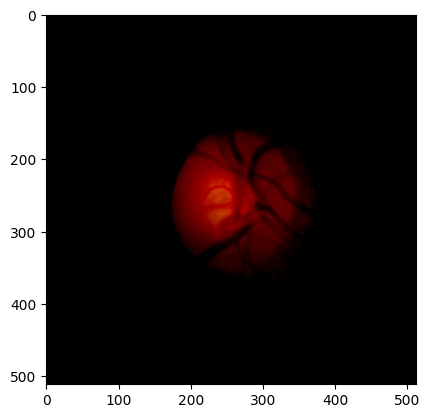

In [19]:
# data, target, img_name = sample['image'], sample['map'], sample['img_name']
# if torch.cuda.is_available():
#     data, target = data.cuda(), target.cuda()
# data, target = Variable(data), Variable(target)

prediction, boundary, last_conv_feats = model(data)
prediction = torch.sigmoid(prediction)

target_numpy = target.data.cpu()
prediction = prediction.data.cpu()
prediction[prediction>0.75] = 1;prediction[prediction <= 0.75] = 0


cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])

# fig,axes = plt.subplots(1,3,figsize=(15,5))
print(data.shape)
plt.imshow(data[0].cpu().numpy().transpose(1, 2, 0))
plt.show()


IMG: ['G-22-L.png'] CUP_DICE: [0.58201606] DISC_DICE: 0.931004906849643


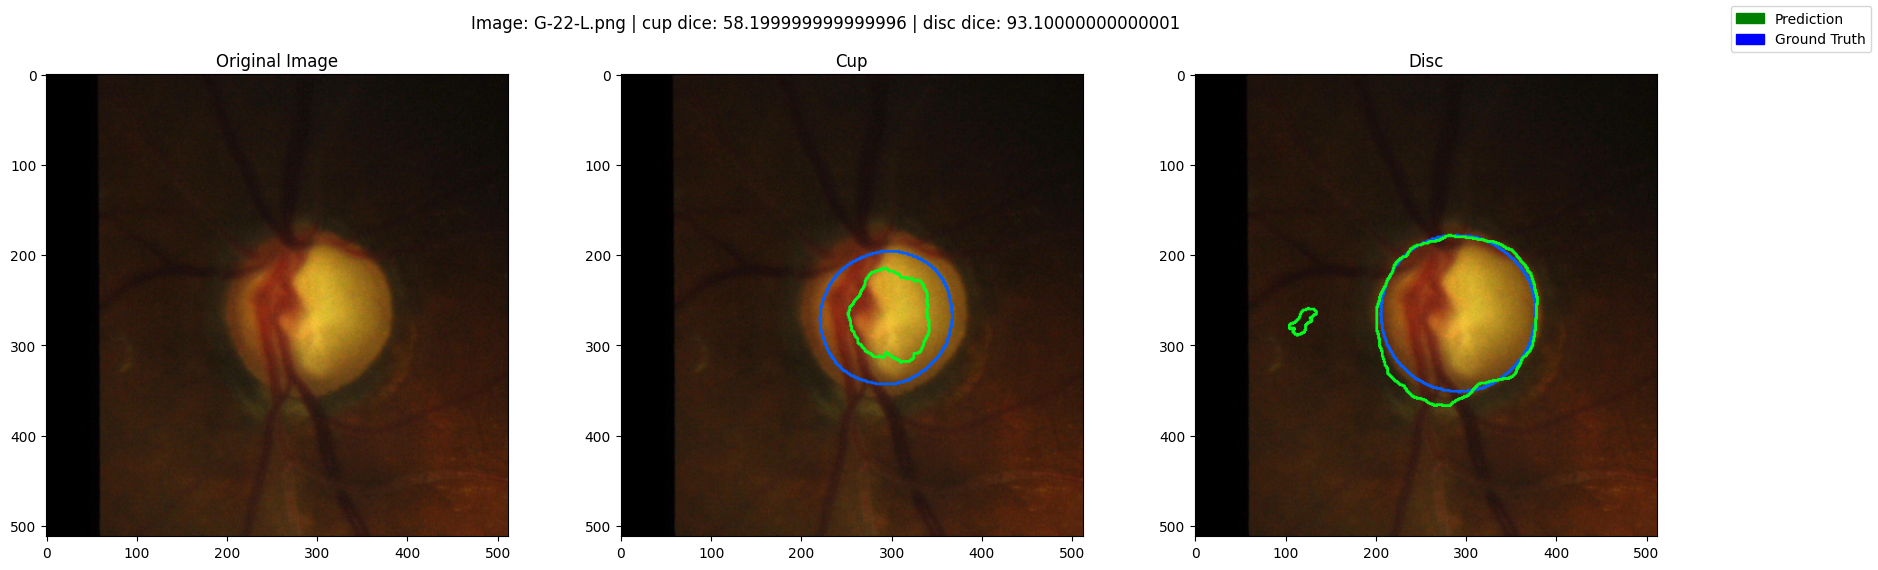

In [39]:
from torchvision.utils import make_grid
import matplotlib.patches as mpatches


model = model.train()

def add_mask(img,mask):  
    label2color = {0:np.array([0,0,0]),1:np.array([224/255,255/255,255/255])
                #    ,2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])
                   }
    
    
    # pred_mask = np.zeros_like(img).astype(np.uint8)
    pred_mask = np.zeros_like(img).astype(np.float32)
    # print(pred_mask.shape)
    # print(mask.shape)
    for l,color in label2color.items():
        # print(pred_mask[:, mask==l].shape)
        # print((mask==l).shape)
        pred_mask[:, mask==l] = np.expand_dims(color,1)
    img_pred = cv2.addWeighted(img,0.5,pred_mask,0.5,0,0)
    return img_pred

def add_mask_outline(img, mask, gt):
    label2color = {0:np.array([0,0,0]),1:np.array([224/255,255/255,255/255])
                #    ,2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])
    }
    mask = mask.astype(np.uint8)
    gt = gt.astype(np.uint8)
    img = (img * 255).astype(np.uint8).copy()
    
    colors = [(3, 94, 252), (3, 252, 32)]
    masks = [mask, gt]
    
    for color, mask in zip(colors, masks):
        cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            cv2.drawContours(img, [c], -1, color, thickness=2)
    return img

def create_visuals(inspect_dict, data, target, img_name, prediction, target_numpy, cup_dice, disc_dice):
    classes = [0,1]
    classes_names = ['cup', 'disc']
    dice_scores = [cup_dice, disc_dice]
    print(f"IMG: {img_name} CUP_DICE: {cup_dice} DISC_DICE: {disc_dice[0]}")
    show_images = []
    view_img = make_grid(
                        data[0, ...].clone().cpu().data, 1, normalize=True).detach().cpu().numpy()
    show_images.append(view_img.transpose(1,2,0))
    for name,class_id,dice_score in zip(classes_names, classes, dice_scores):
                # print(data.detach().cpu().numpy()[0].shape)
                # print(f"max data {data.max()} min data {data.min()}")
                
                # print(view_img.dtype)
        gt_mask = target_numpy.detach().cpu().numpy()[:,class_id, ...].transpose(1, 2, 0)
        pred_mask = prediction.detach().cpu().numpy()[:,class_id, ...].transpose(1, 2, 0)
                # print(view_img.shape)
                # print(gt_mask.shape)                
        masked_im = add_mask_outline(view_img.transpose(1,2,0), gt_mask[:,:,0], pred_mask[:,:,0])
                # masked_pred = add_mask_outline(view_img.transpose(1,2,0), pred_mask[:,:,0])
        show_images.append(masked_im)
    fig,axes = plt.subplots(1,3,figsize=(21,6))
            
    fig.suptitle(f"Image: {img_name[0]} | {classes_names[0]} dice: {round(cup_dice[0], 4) * 100} | {classes_names[1]} dice: {round(disc_dice[0], 4) * 100}")
    green_patch = mpatches.Patch(color='green', label='Prediction')
    blue_patch = mpatches.Patch(color='blue', label='Ground Truth')
    fig.legend(handles=[green_patch, blue_patch])
            
    axes[0].title.set_text("Original Image")
    axes[0].imshow(view_img.transpose(1,2,0))
    axes[1].title.set_text("Cup")
    axes[1].imshow(show_images[1])
    axes[2].imshow(prediction.detach().cpu().numpy()[:,0, ...].transpose(1, 2, 0))
    axes[2].title.set_text("Disc")
    axes[2].imshow(show_images[2])

    inspect_dict[img_name[0]] = (data, target, img_name)
    plt.show()
    

get_hd = True
val_cup_dice = 0.0;val_disc_dice = 0.0;datanum_cnt = 0.0
cup_hd = 0.0; disc_hd = 0.0;datanum_cnt_cup = 0.0;datanum_cnt_disc = 0.0
cnt_low_dice = 0.0
inspect_dict = {}

with torch.no_grad():
    for batch_idx, (sample) in enumerate(test_loader):
        data, target, img_name = sample['image'], sample['map'], sample['img_name']
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        prediction, boundary, _ = model(data)
        prediction = torch.sigmoid(prediction)

        target_numpy = target.data.cpu()
        prediction = prediction.data.cpu()
        prediction[prediction>0.75] = 1;prediction[prediction <= 0.75] = 0


        cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
        disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])

        # print("cup_dice: ", cup_dice)
        # print("disc_dice: ", disc_dice)
        
        if cup_dice < 0.6:
            create_visuals(inspect_dict, data, target, img_name, prediction, target_numpy, cup_dice, disc_dice)
            cnt_low_dice += prediction.shape[0]
            break
            
        for i in range(prediction.shape[0]):
            hd_tmp = hd_numpy(prediction[i, 0, ...], target_numpy[i, 0, ...], get_hd)
            if np.isnan(hd_tmp):
                datanum_cnt_cup -= 1.0
            else:
                cup_hd += hd_tmp

            hd_tmp = hd_numpy(prediction[i, 1, ...], target_numpy[i, 1, ...], get_hd)
            if np.isnan(hd_tmp):
                datanum_cnt_disc -= 1.0
            else:
                disc_hd += hd_tmp

        val_cup_dice += np.sum(cup_dice)
        val_disc_dice += np.sum(disc_dice)

        datanum_cnt += float(prediction.shape[0])
        datanum_cnt_cup += float(prediction.shape[0])
        datanum_cnt_disc += float(prediction.shape[0])


In [40]:
print(inspect_dict.keys())          

dict_keys(['G-22-L.png'])


In [43]:
img_name = list(inspect_dict.keys())[0]
print(f"Working on {img_name}...")

if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target)
prediction, boundary, _ = model(data)
prediction = torch.sigmoid(prediction)

target_numpy = target.data.cpu()
prediction = prediction.data.cpu()
prediction[prediction>0.75] = 1;prediction[prediction <= 0.75] = 0


cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])



Working on G-22-L.png...


In [44]:
# val_cup_dice /= datanum_cnt
# val_disc_dice /= datanum_cnt
# cup_hd /= datanum_cnt_cup
# disc_hd /= datanum_cnt_disc

# print("cup: %.4f disc: %.4f avg: %.4f cup: %.4f disc: %.4f avg: %.4f" %
# (val_cup_dice, val_disc_dice, (val_cup_dice+val_disc_dice)/2.0, cup_hd, disc_hd, (cup_hd+disc_hd)/2.0))
# # print("best cup: %.4f best disc: %.4f best avg: %.4f best cup: %.4f best disc: %.4f best avg: %.4f" %
# # (best_val_cup_dice, best_val_disc_dice, best_avg, best_cup_hd, best_disc_hd, best_avg_hd))

# print("num of low dice: ", cnt_low_dice)
# print("num of total images: ", datanum_cnt_cup)

# # cup: 0.8773 disc: 0.9537 avg: 0.9155 cup: 6.8760 disc: 7.4139 avg: 7.1449

cup: 0.8100 disc: 0.8960 avg: 0.8530 cup: 8.6315 disc: 9.8881 avg: 9.2598
num of low dice:  1.0
num of total images:  18.0


In [45]:
print(target_numpy.shape)
tmp = target_numpy.squeeze()

combined_mask = torch.zeros_like(tmp[0])
for i in range(tmp.shape[0]):
    combined_mask[torch.logical_and(tmp[i] == True ,combined_mask == False)] = i + 1

print(combined_mask.max()) 
print(combined_mask.min()) 
print(combined_mask.unique()) 
concat_labels = torch.flatten(combined_mask)
print(concat_labels.shape)



torch.Size([1, 2, 512, 512])
tensor(2.)
tensor(0.)
tensor([0., 1., 2.])
torch.Size([262144])


In [129]:
print(last_conv_feats.shape)
print(prediction.shape)

print(last_conv_feats.shape)

features_before_last_conv = last_conv_preprocess(last_conv_feats)

interpolated_feats = F.interpolate(features_before_last_conv, size=data.size()[2:], mode='bilinear', align_corners=True)

print(interpolated_feats.shape)


tsne_feats = torch.flatten(interpolated_feats.squeeze(), 1)

one_feats = tsne_feats[:, concat_labels == 1][:,:1500]
two_feats = tsne_feats[:, concat_labels == 2][:,:1500]
zero_feats = tsne_feats[:, concat_labels == 0][:,:1500]

reduced_feats = torch.cat((one_feats, two_feats, zero_feats), 1)

print(one_feats.shape)
print(two_feats.shape)
print(reduced_feats.shape)
print(tsne_feats.shape)

# tsne_output = compute_tsne(reduced_feats.cpu().detach().transpose(0,1).numpy())

torch.Size([1, 305, 128, 128])
torch.Size([1, 2, 512, 512])
torch.Size([1, 305, 128, 128])
torch.Size([1, 305, 512, 512])
torch.Size([305, 1500])
torch.Size([305, 1500])
torch.Size([305, 4500])
torch.Size([305, 262144])


(4500, 2)
(4500,)
(4500,)
###########
False
False


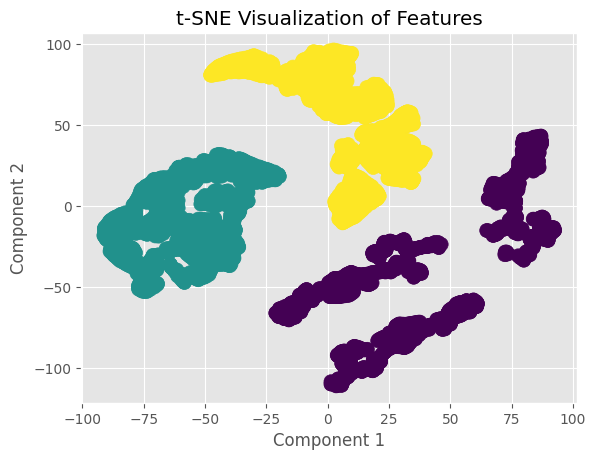

In [12]:
print(tsne_output.shape)
concat_labels = [1]*1500 + [2]*1500 + [0]*1500
show_tsne_plot(tsne_output.transpose(0,1), concat_labels[:4500])

In [83]:
# try checking out prototypes
prototypes = None
bias = None
for name, p in model.named_parameters():
    if 'decoder.last_conv.3.weight' in name:
        prototypes = p
    if 'decoder.last_conv.3.bias' in name:
        bias = p

print(prototypes.shape)
print(reduced_feats.shape)


# Note - might need to take bias into account !
prototypes = (prototypes - prototypes.mean()) / prototypes.std()
class_0_prototypes = prototypes[0,:,0,0]
class_1_prototypes = prototypes[1,:,0,0]

print(f"bias shape {bias.shape}")
print(bias)
print(class_0_prototypes.shape)
print(class_1_prototypes.shape)

print(class_0_prototypes[:10])
print(class_1_prototypes[:10])

torch.Size([2, 305, 1, 1])
torch.Size([305, 4502])
bias shape torch.Size([2])
Parameter containing:
tensor([-0.0517, -0.0596], device='cuda:0', requires_grad=True)
torch.Size([305])
torch.Size([305])
tensor([-0.0388, -1.0548,  0.9833,  0.7374, -0.6600,  1.3429, -1.3896,  0.3230,
         1.2621, -0.1469], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6673, -0.0297, -0.7197,  1.7772,  0.0171,  0.2662, -1.0712,  1.4142,
         0.2093, -1.2021], device='cuda:0', grad_fn=<SliceBackward0>)


In [130]:
print(one_feats.shape)
reduced_feats = torch.cat((one_feats, two_feats, zero_feats), 1)

#normalize
reduced_feats = (reduced_feats - reduced_feats.mean()) / reduced_feats.std()

print(reduced_feats.shape)
print(class_0_prototypes.unsqueeze(1).shape)
reduced_feats = torch.cat((reduced_feats, class_0_prototypes.unsqueeze(1), class_1_prototypes.unsqueeze(1)), 1)

print(one_feats.shape)
print(two_feats.shape)
print(reduced_feats.shape)
print(tsne_feats.shape)

print(class_0_prototypes.shape)


tsne_output = compute_tsne(reduced_feats.cpu().detach().transpose(0,1).numpy())



torch.Size([305, 1500])
torch.Size([305, 4500])
torch.Size([305, 1])
torch.Size([305, 1500])
torch.Size([305, 1500])
torch.Size([305, 4502])
torch.Size([305, 262144])
torch.Size([305])


/home/yandex/DL20222023a/baryaacovi/anaconda3/envs/meant/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yandex/DL20222023a/baryaacovi/anaconda3/envs/meant/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(4502, 2)
(4502,)
(4502,)
###########
False
False
-2
[1, 2]


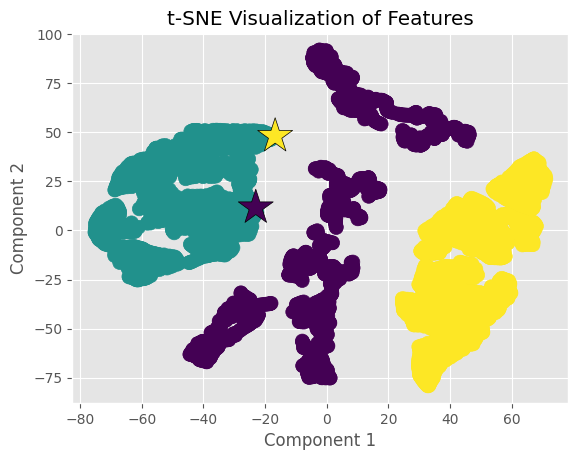

(4502,)
(4502,)
(2,)
(2,)
[1, 2]


In [131]:
print(tsne_output.shape)
concat_labels = [1]*1500 + [2]*1500 + [0]*1500 + [1]*1 + [2] * 1
show_tsne_plot(tsne_output.transpose(0,1), concat_labels[:4503], num_prototypes=2)

print(tsne_output[:, 0].shape) 
print(tsne_output[:, 1].shape) 
print(tsne_output[-2:, 0].shape) 
print(tsne_output[-2:, 1].shape) 
print(concat_labels[-2:])
# print(tsne_output[-1])
# print(tsne_output[-2])

